In [55]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, Bidirectional
from sklearn.model_selection import train_test_split

In [493]:
n=100000
m=100
total=n+m
delta_t=0.01
s=5

def lorenz(x, y, z, s=10, r=28, b=2.667):
    '''
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    '''
    x_dot = s*(y-x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot

# Need one more for the initial values
xs = np.empty(total + 1)
ys = np.empty(total + 1)
zs = np.empty(total + 1)

# Set initial values
xs[0], ys[0], zs[0] = (0., 1., 1.05)

# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(total):
    x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (x_dot * delta_t)
    ys[i + 1] = ys[i] + (y_dot * delta_t)
    zs[i + 1] = zs[i] + (z_dot * delta_t)

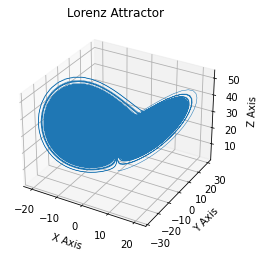

In [494]:
# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(xs, ys, zs, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

In [495]:
# Scaled to work with Neural networks.
xs_scaled = (xs-np.min(xs))/(np.max(xs)-np.min(xs))
ys_scaled = (ys-np.min(ys))/(np.max(ys)-np.min(ys))
zs_scaled = (zs-np.min(zs))/(np.max(zs)-np.min(zs))

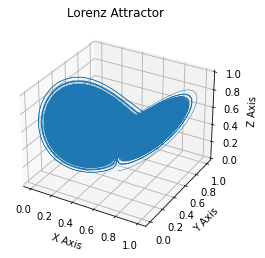

In [496]:
# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(xs_scaled, ys_scaled, zs_scaled, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

In [497]:
xs1_train = []
xs2_train = []
for i in range(s,n):
    xs1_train.append(xs_scaled[i-s:i])
    xs2_train.append(xs_scaled[i])
xs1_train, xs2_train = np.array(xs1_train), np.array(xs2_train)

In [498]:
ys1_train = []
ys2_train = []
for i in range(s,n):
    ys1_train.append(ys_scaled[i-s:i])
    ys2_train.append(ys_scaled[i])
ys1_train, ys2_train = np.array(ys1_train), np.array(ys2_train)

In [499]:
zs1_train = []
zs2_train = []
for i in range(s,n):
    zs1_train.append(zs_scaled[i-s:i])
    zs2_train.append(zs_scaled[i])
zs1_train, zs2_train = np.array(zs1_train), np.array(zs2_train)

In [525]:
print(xs2_train[-1])
print(ys2_train[-1])
print(zs2_train[-1])

0.3763261908730003
0.3639158976385806
0.3167527295849813


In [501]:
def LSTM_model(input_):
    print('encoder')
    print(input_.shape)
    x = LSTM(128,input_shape=(s,3))(input_)
    print(x.shape)
    output = Dense(3)(x)
    print(output.shape)
    return output

In [502]:
def LSTM_model(input_):
    print('encoder')
    print(input_.shape)
    x = Bidirectional(LSTM(128, input_shape=(s,3), return_sequences=True))(input_)
    x = Bidirectional(LSTM(128))(x)
    print(x.shape)
    output = Dense(3,activation="sigmoid")(x)
    print(output.shape)
    return output

In [503]:
input_ = tensorflow.keras.Input(shape=(s,3))
LSTM_model = tensorflow.keras.Model(input_, LSTM_model(input_))

encoder
(None, 5, 3)
(None, 256)
(None, 3)


In [504]:
opt = tensorflow.keras.optimizers.Adam()
LSTM_model.compile(optimizer=opt, loss='mse')
LSTM_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 5, 3)]            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 5, 256)            135168    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 771       
Total params: 530,179
Trainable params: 530,179
Non-trainable params: 0
_________________________________________________________________


In [505]:
X_train=np.concatenate((xs1_train.reshape(-1,s,1), ys1_train.reshape(-1,s,1), zs1_train.reshape(-1,s,1)), axis=2)
y_train=np.concatenate((xs2_train.reshape(-1,1),ys2_train.reshape(-1,1),zs2_train.reshape(-1,1)),axis=1)

In [506]:
X_train.shape

(99995, 5, 3)

In [507]:
y_train.shape

(99995, 3)

In [508]:
epochs=20
LSTM_model.fit(X_train,y_train,epochs=epochs,batch_size=128)

Epoch 1/20
782/782 [==============================] - 26s 29ms/step - loss: 0.0032
Epoch 2/20
782/782 [==============================] - 23s 30ms/step - loss: 2.6181e-05
Epoch 3/20
782/782 [==============================] - 23s 30ms/step - loss: 9.0578e-06
Epoch 4/20
782/782 [==============================] - 23s 30ms/step - loss: 5.3933e-06
Epoch 5/20
782/782 [==============================] - 23s 29ms/step - loss: 4.8281e-06
Epoch 6/20
782/782 [==============================] - 23s 29ms/step - loss: 3.2916e-06
Epoch 7/20
782/782 [==============================] - 22s 29ms/step - loss: 4.2035e-06
Epoch 8/20
782/782 [==============================] - 22s 28ms/step - loss: 1.9561e-06
Epoch 9/20
782/782 [==============================] - 22s 28ms/step - loss: 4.1933e-06
Epoch 10/20
782/782 [==============================] - 22s 28ms/step - loss: 2.3679e-06
Epoch 11/20
782/782 [==============================] - 22s 28ms/step - loss: 2.8226e-06
Epoch 12/20
782/782 [========================

In [509]:
#LSTM_model.save('LSTM_model.h5')

In [511]:
import tensorflow as tf
LSTM_model = tf.keras.models.load_model('LSTM_model.h5')

In [512]:
y_train_pred=LSTM_model.predict(X_train)

In [513]:
y_train_pred.shape

(99995, 3)

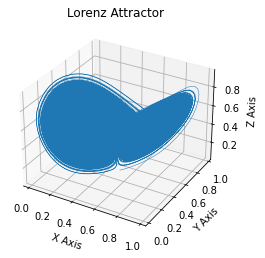

In [514]:
# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(y_train_pred[:,0], y_train_pred[:,1], y_train_pred[:,2], lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

(99900.0, 100000.0)

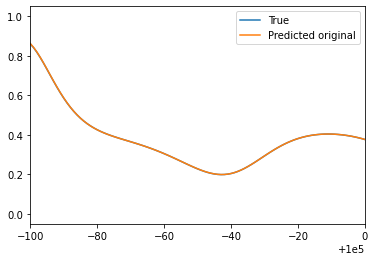

In [515]:
plt.plot(np.linspace(0,n,n),xs_scaled[:n],label='True')
plt.plot(np.linspace(s,n,n-s),y_train_pred[:,0],label='Predicted original')
plt.legend()
plt.xlim([99900,100000])

In [75]:
np.linspace(s,len(xs_scaled),len(xs_scaled)-s-1).shape

(99995,)

(99900.0, 100000.0)

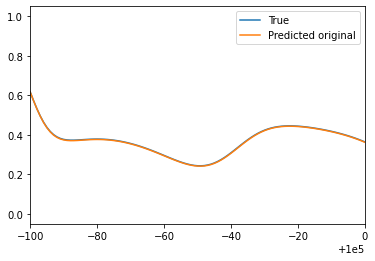

In [517]:
plt.plot(np.linspace(0,n,n),ys_scaled[:n],label='True')
plt.plot(np.linspace(s,n,n-s),y_train_pred[:,1],label='Predicted original')
plt.legend()
#plt.xlim([0,100])
plt.xlim([99900,100000])

(99900.0, 100000.0)

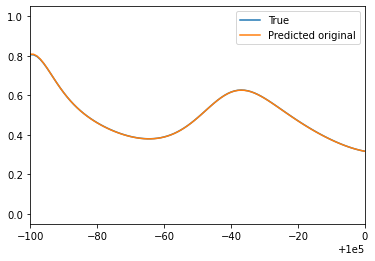

In [518]:
plt.plot(np.linspace(0,n,n),zs_scaled[:n],label='True')
plt.plot(np.linspace(s,n,n-s),y_train_pred[:,2],label='Predicted original')
plt.legend()
#plt.xlim([0,200])
plt.xlim([99900,100000])

## Predicting the future

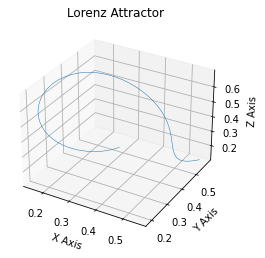

In [521]:
# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(xs_scaled[n:n+m], ys_scaled[n:n+m], zs_scaled[n:n+m], lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

In [526]:
print(xs_scaled[n:n+m][0])
print(ys_scaled[n:n+m][0])
print(zs_scaled[n:n+m][0])

0.37107601363477277
0.35644184001462026
0.3140319416022453


In [536]:
xs1_f = []; xs2_f = []
ys1_f = []; ys2_f = []
zs1_f = []; zs2_f = []

xs1_f.append(X_train[-1,:,0])
ys1_f.append(X_train[-1,:,1])
zs1_f.append(X_train[-1,:,2])

yf=[]

for j in range(m):
    X1 = np.concatenate((xs1_f[-1].reshape(-1,s,1), ys1_f[-1].reshape(-1,5,1), zs1_f[-1].reshape(-1,5,1)), axis=2)
    y_f = LSTM_model.predict(X1)
    xs2_f.append(y_f[0][0]); ys2_f.append(y_f[0][1]); zs2_f.append(y_f[0][2])
    a=np.hstack((X1[0,1:,:].reshape(1,4,3),y_f[-1].reshape(1,1,3)))   
    xs1_f.append(a[0][:,0]); ys1_f.append(a[0][:,1]); zs1_f.append(a[0][:,2])


In [537]:
print(xs2_f[0])
print(ys2_f[0])
print(zs2_f[0])

0.37642622
0.36219594
0.31674322


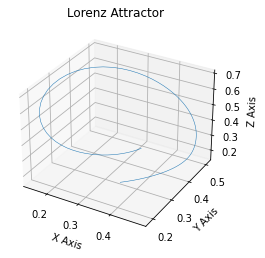

In [538]:
# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(xs2_f, ys2_f, zs2_f, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

(0.0, 100.0)

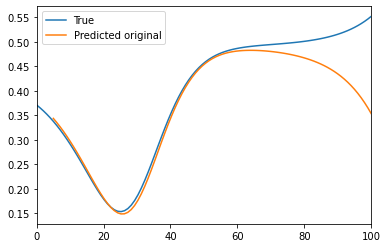

In [541]:
plt.plot(np.linspace(0,m,m),xs_scaled[n:n+m],label='True')
plt.plot(np.linspace(s,m,m-s),xs2_f[s:],label='Predicted original')
plt.legend()
plt.xlim([0,100])

(0.0, 100.0)

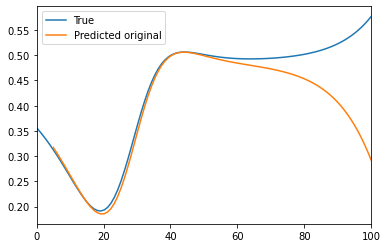

In [542]:
plt.plot(np.linspace(0,m,m),ys_scaled[n:n+m],label='True')
plt.plot(np.linspace(s,m,m-s),ys2_f[s:],label='Predicted original')
plt.legend()
plt.xlim([0,100])

(0.0, 100.0)

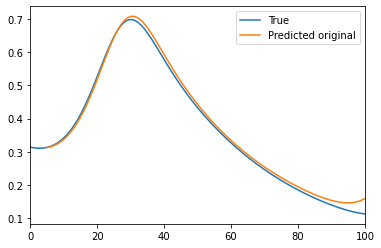

In [543]:
plt.plot(np.linspace(0,m,m),zs_scaled[n:n+m],label='True')
plt.plot(np.linspace(s,m,m-s),zs2_f[s:],label='Predicted original')
plt.legend()
plt.xlim([0,100])